<a href="https://colab.research.google.com/github/mchchoi/permutation/blob/main/EA_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

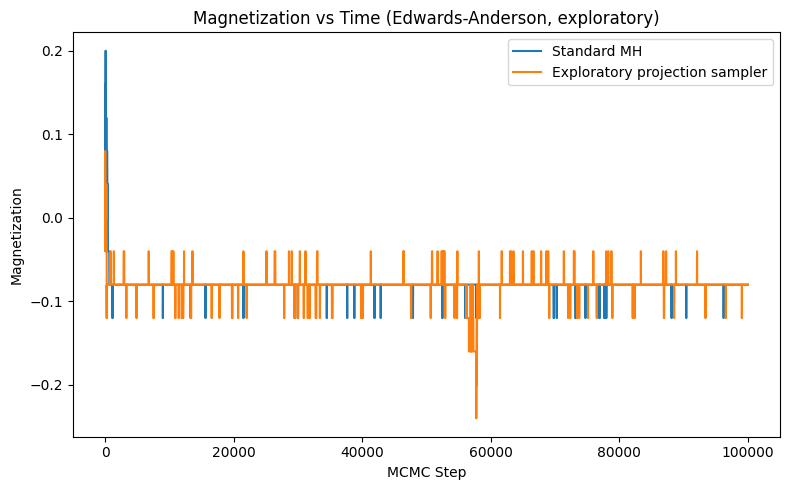

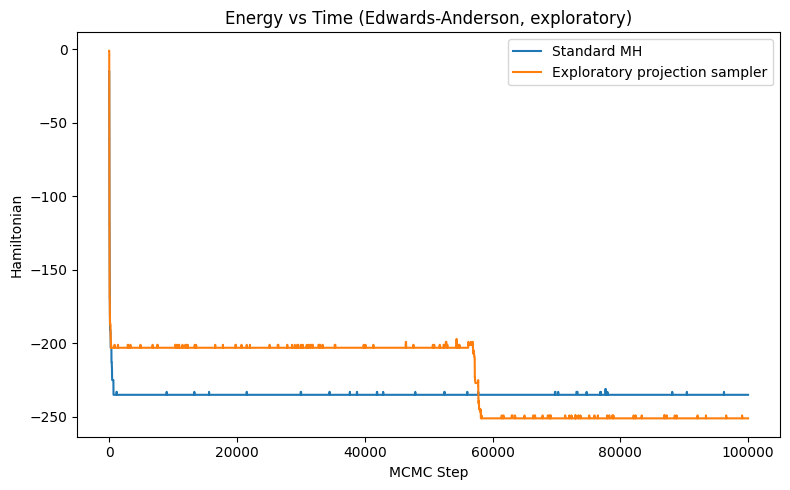

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
np.random.seed(10)
d = 50                # Number of spins
n_explore = 100000      # Exploration steps for building Q
n_sample = 100000       # Sampling steps using projection sampler
beta_high = 0.1       # High temperature for exploration
beta_target = 2     # Target inverse temperature
tolerance = 1e-6      # Energy comparison tolerance

# --- Generate ±J Couplings ---
J = np.random.choice([-1, 1], size=(d, d))
J = np.triu(J, 1)
J += J.T
np.fill_diagonal(J, 0)

# --- Hamiltonian for ±J Spin Glass ---
def hamiltonian(x):
    return -0.5 * np.sum(J * np.outer(x, x))

# --- Standard Metropolis-Hastings Step ---
def metropolis_step(x, beta):
    x_new = x.copy()
    i = np.random.randint(d)
    x_new[i] *= -1
    delta_H = hamiltonian(x_new) - hamiltonian(x)
    if np.random.rand() < np.exp(-beta * delta_H):
        return x_new
    else:
        return x

# --- Exploration Phase using High-Temp MH ---
x = np.random.choice([-1, 1], size=d)
original = x
trajectory = []
energies = []

for _ in range(n_explore):
    x = metropolis_step(x, beta_high)
    trajectory.append(x.copy())
    energies.append(hamiltonian(x))

# --- Build Q from Exploration Trajectory ---
Q_dict = {}
for i in range(n_explore):
    x_i = trajectory[i]
    x_i_str = x_i.tobytes()
    if x_i_str in Q_dict:
        continue
    H_i = energies[i]
    for j in range(i + 1, n_explore):
        x_j = trajectory[j]
        x_j_str = x_j.tobytes()
        if x_j_str in Q_dict:
            continue
        if np.isclose(H_i, energies[j], atol=tolerance):
            Q_dict[x_i_str] = x_j.copy()
            Q_dict[x_j_str] = x_i.copy()
            break

# --- Define Q Permutation ---
def Q_permutation(x):
    x_str = x.tobytes()
    return Q_dict.get(x_str, x.copy())

# --- Projection Metropolis Step using Fixed Q ---
def metropolis_step_projection(x, beta):
    y1 = metropolis_step(x, beta)
    #y1 = metropolis_step(Q_permutation(x), beta)
    y2 = Q_permutation(metropolis_step(Q_permutation(x), beta))
    #y2 = Q_permutation(metropolis_step(x, beta))
    return y1 if np.random.rand() < 0.5 else y2

# --- Magnetization ---
def magnetization(x):
    return np.mean(x)

# --- Run Sampling Phase ---
#x_proj = np.random.choice([-1, 1], size=d)
x_proj = original
x_std = x_proj.copy()

mag_proj = np.zeros(n_sample)
mag_std = np.zeros(n_sample)
energy_proj = np.zeros(n_sample)
energy_std = np.zeros(n_sample)

for t in range(n_sample):
    x_proj = metropolis_step_projection(x_proj, beta_target)
    x_std = metropolis_step(x_std, beta_target)

    mag_proj[t] = magnetization(x_proj)
    mag_std[t] = magnetization(x_std)
    energy_proj[t] = hamiltonian(x_proj)
    energy_std[t] = hamiltonian(x_std)

# --- Plot Results ---
plt.figure(figsize=(8, 5))
plt.plot(mag_std, label='Standard MH')
plt.plot(mag_proj, label='Exploratory projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Magnetization')
plt.title('Magnetization vs Time (Edwards-Anderson, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_magnetization_exploratory.png')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(energy_std, label='Standard MH')
plt.plot(energy_proj, label='Exploratory projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Hamiltonian')
plt.title('Energy vs Time (Edwards-Anderson, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_energy_exploratory.png')
plt.show()



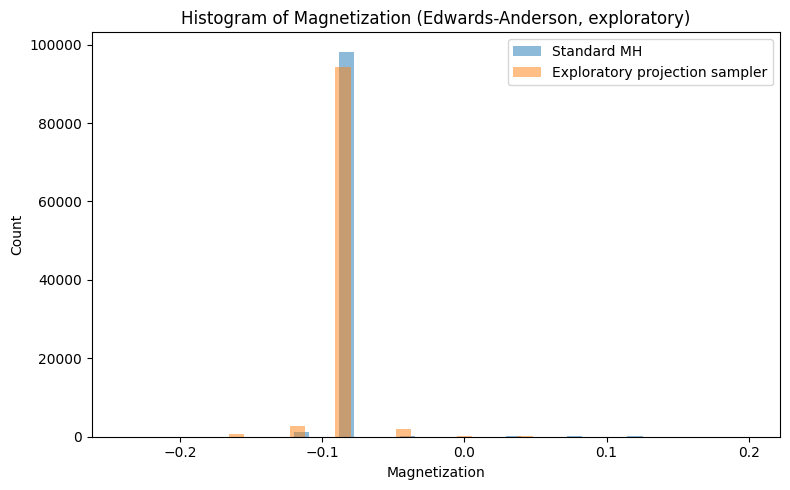

In [2]:
plt.figure(figsize=(8, 5))
plt.hist(mag_std[-100000:], bins=30, alpha=0.5, label='Standard MH', density=False)
plt.hist(mag_proj[-100000:], bins=30, alpha=0.5, label='Exploratory projection sampler', density=False)
plt.xlabel('Magnetization')
plt.ylabel('Count')
plt.title('Histogram of Magnetization (Edwards-Anderson, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_histogram_exploratory.png')
plt.show()